In [1]:
# Install pandas and Excel support (openpyxl) into the current Python environment
%pip install pandas openpyxl

In [2]:
#upload creditcard data file
# Quietly install pandas + Excel engine (openpyxl)
# Launch Colab uploader to pick .xlsx/.xls/.csv
# If Excel: choose sheet containing 'Class' (fallback: first sheet)
# Load to DataFrame, ensure data/ folder, and save as data/creditcard.csv
# Print confirmation with shape
%pip install pandas openpyxl --quiet
import pandas as pd
from pathlib import Path
from google.colab import files

uploaded = files.upload()  # pick your .xlsx/.xls or .csv
fname = next(iter(uploaded.keys()))

def guess_sheet(xl):
    for s in xl.sheet_names:
        head = xl.parse(s, nrows=5)
        if "Class" in head.columns:
            return s
    return xl.sheet_names[0]

if fname.lower().endswith(('.xlsx', '.xls')):
    xl = pd.ExcelFile(fname)
    sheet = guess_sheet(xl)
    df = xl.parse(sheet_name=sheet)
else:
    df = pd.read_csv(fname)

Path("data").mkdir(parents=True, exist_ok=True)
df.to_csv("data/creditcard.csv", index=False)
print("✅ Saved to data/creditcard.csv | Shape:", df.shape)

Saving creditcard.csv to creditcard.csv
✅ Saved to data/creditcard.csv | Shape: (284807, 31)


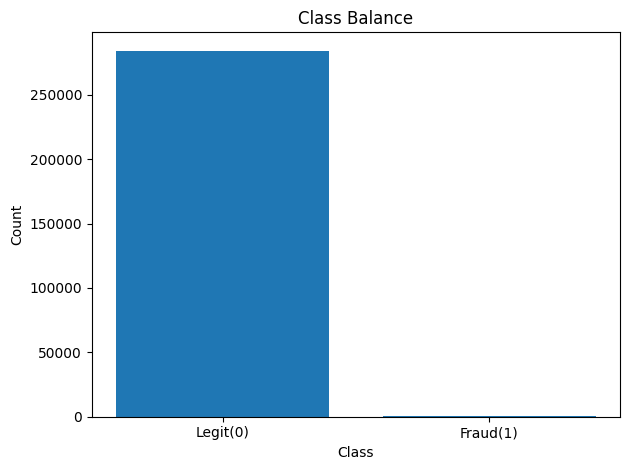

Top 10 missingness (%):
Time    0.0
V1      0.0
V2      0.0
V3      0.0
V4      0.0
V5      0.0
V6      0.0
V7      0.0
V8      0.0
V9      0.0
dtype: float64


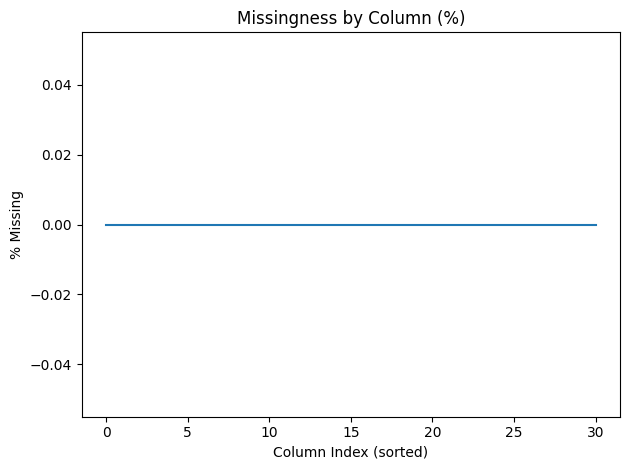

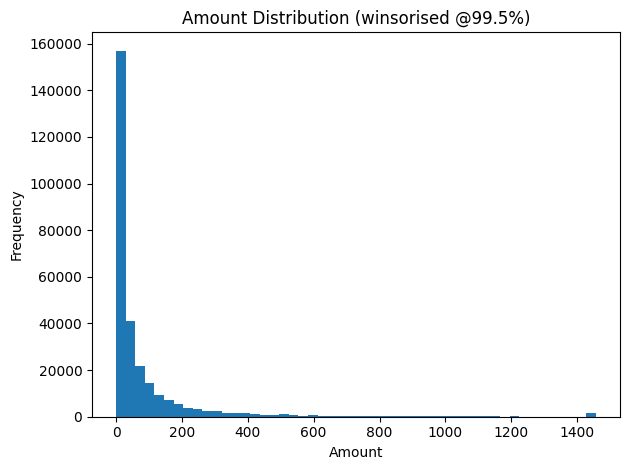

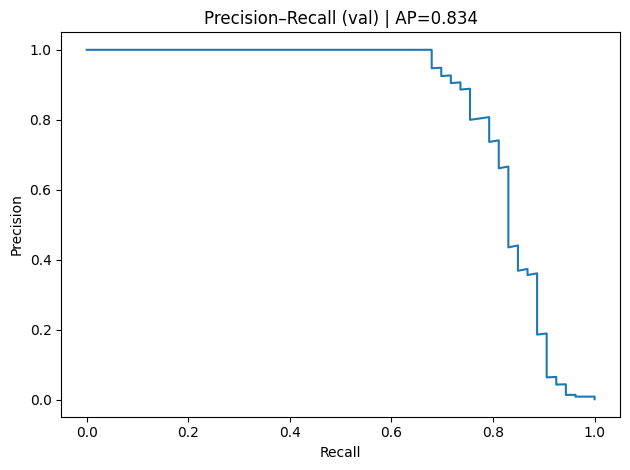

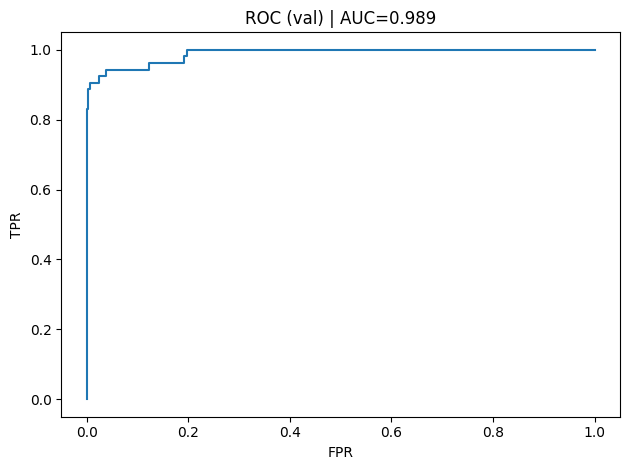

{'average_precision': 0.8339799253416804, 'roc_auc': 0.9888530043459677, 'brier': 0.016117418937950802}
✅ Saved figures to: /content/reports/figures


In [3]:
# Quietly install deps → load data/creditcard.csv → make reports/figures/
# EDA: class balance, missingness, amount histogram (winsorised)
# Split (temporal if 'Time'); baseline Pipeline: StandardScaler + LogisticRegression (balanced)
# Validate → save PR/ROC curves, print AP/ROC AUC/Brier; figures saved under reports/figures/
%pip install -q pandas numpy matplotlib scikit-learn

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, brier_score_loss
from sklearn.pipeline import Pipeline

# 1) Load the CSV saved by your previous cell
csv_path = Path("data/creditcard.csv")
assert csv_path.exists(), "Couldn't find data/creditcard.csv — rerun the upload cell first."
df = pd.read_csv(csv_path)

# 2) Prepare output dir
outdir = Path("reports/figures")
outdir.mkdir(parents=True, exist_ok=True)

# 3) Class balance plot
counts = df['Class'].value_counts().sort_index()
plt.figure()
plt.bar(['Legit(0)','Fraud(1)'], counts.values)
plt.title('Class Balance')
plt.xlabel('Class'); plt.ylabel('Count')
plt.tight_layout(); plt.savefig(outdir/'class_balance.png', dpi=150)
plt.show()

# 4) Missingness (quick view)
missing = df.isna().mean().sort_values(ascending=False) * 100
print("Top 10 missingness (%):")
print(missing.head(10))
plt.figure()
plt.plot(range(len(missing)), missing.values)
plt.title('Missingness by Column (%)')
plt.xlabel('Column Index (sorted)'); plt.ylabel('% Missing')
plt.tight_layout(); plt.savefig(outdir/'missingness.png', dpi=150)
plt.show()

# 5) Amount histogram (winsorised for readability)
amt = df['Amount'].clip(upper=df['Amount'].quantile(0.995))
plt.figure()
plt.hist(amt, bins=50)
plt.title('Amount Distribution (winsorised @99.5%)')
plt.xlabel('Amount'); plt.ylabel('Frequency')
plt.tight_layout(); plt.savefig(outdir/'amount_hist.png', dpi=150)
plt.show()

# 6) Simple baseline (validation PR/ROC/Brier)
X = df.drop(columns=['Class'])
y = df['Class']

# Temporal-style split if 'Time' exists; otherwise stratified split
if 'Time' in X.columns:
    df_sorted = df.sort_values('Time')
    cut1 = int(len(df_sorted)*0.8)
    cut2 = int(len(df_sorted)*0.9)
    train = df_sorted.iloc[:cut1]
    val = df_sorted.iloc[cut1:cut2]
    test = df_sorted.iloc[cut2:]
    X_train, y_train = train.drop(columns=['Class']), train['Class']
    X_val, y_val = val.drop(columns=['Class']), val['Class']
else:
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(max_iter=200, class_weight='balanced'))
])
pipe.fit(X_train, y_train)

proba_val = pipe.predict_proba(X_val)[:, 1]

# PR curve
precision, recall, _ = precision_recall_curve(y_val, proba_val)
ap = average_precision_score(y_val, proba_val)
plt.figure()
plt.plot(recall, precision)
plt.title(f'Precision–Recall (val) | AP={ap:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.tight_layout(); plt.savefig(outdir/'pr_curve_val.png', dpi=150)
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_val, proba_val)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr)
plt.title(f'ROC (val) | AUC={roc_auc:.3f}')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.tight_layout(); plt.savefig(outdir/'roc_curve_val.png', dpi=150)
plt.show()

# Brier score (calibration proxy)
brier = brier_score_loss(y_val, proba_val)
print({'average_precision': float(ap), 'roc_auc': float(roc_auc), 'brier': float(brier)})

print("✅ Saved figures to:", outdir.resolve())

In [4]:
# reInstall required libraries in the Colab environment (quiet mode).
%pip install -q pandas openpyxl
import pandas as pd
from pathlib import Path
from google.colab import files

uploaded = files.upload()   # pick your .xlsx/.xls or .csv
fname = next(iter(uploaded.keys()))

def guess_sheet(xl):
    for s in xl.sheet_names:
        if "Class" in xl.parse(s, nrows=5).columns:
            return s
    return xl.sheet_names[0]

Path("data").mkdir(parents=True, exist_ok=True)

if fname.lower().endswith(('.xlsx', '.xls')):
    xl = pd.ExcelFile(fname)
    sheet = guess_sheet(xl)
    df = xl.parse(sheet_name=sheet)
else:
    df = pd.read_csv(fname)

out_path = Path("data/creditcard.csv")
df.to_csv(out_path, index=False)
print("✅ Saved to:", out_path.resolve(), "| shape:", df.shape)

Saving creditcard.csv to creditcard (1).csv
✅ Saved to: /content/data/creditcard.csv | shape: (284807, 31)


In [5]:
# Check runtime’s current working directory and verifies what CSV files exist in the data folder.
# - os.getcwd() prints the folder location where the notebook is currently operating.
# - glob.glob("data/*.csv") searches for and lists all .csv files inside the "data" directory.
import os, glob
print("CWD:", os.getcwd())
print(glob.glob("data/*.csv"))

CWD: /content
['data/creditcard.csv']


In [6]:
# Train baseline + choose threshold + EV table
%pip install -q pandas numpy scikit-learn
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve

csv_path = Path("data/creditcard.csv")
assert csv_path.exists(), "Couldn't find data/creditcard.csv — run the upload cell again."
df = pd.read_csv(csv_path)

# Temporal split if Time exists; otherwise stratified split
if 'Time' in df.columns:
    df = df.sort_values('Time').reset_index(drop=True)
    cut1, cut2 = int(len(df)*0.8), int(len(df)*0.9)
    train = df.iloc[:cut1]; val = df.iloc[cut1:cut2]
    X_train, y_train = train.drop(columns=['Class']), train['Class']
    X_val,   y_val   = val.drop(columns=['Class']),   val['Class']
else:
    X = df.drop(columns=['Class']); y = df['Class']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Baseline model
pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(max_iter=200, class_weight='balanced'))
])
pipe.fit(X_train, y_train)

# Validation scores
val_scores = pd.DataFrame({'y': y_val.values, 'p': pipe.predict_proba(X_val)[:, 1]})

# Business knobs (edit if needed)
K_ALERTS = 500
C_fraud, C_review, C_fp = 7500.0, 80.0, 150.0
FPR_CAP = 0.01

def eval_at_threshold(scores: pd.DataFrame, tau: float):
    pred = (scores['p'] >= tau).astype(int)
    TP = int(((pred==1) & (scores['y']==1)).sum())
    FP = int(((pred==1) & (scores['y']==0)).sum())
    FN = int(((pred==0) & (scores['y']==1)).sum())
    TN = int(((pred==0) & (scores['y']==0)).sum())
    precision = TP / max(TP + FP, 1)
    recall = TP / max(TP + FN, 1)
    fpr = FP / max(FP + TN, 1)
    alerts = TP + FP
    EV = TP*C_fraud - alerts*C_review - FP*C_fp
    return {'tau': float(tau), 'alerts': alerts, 'precision': precision,
            'recall': recall, 'fpr': fpr, 'EV': EV, 'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

# 1) Threshold by alert budget (top-K)
val_sorted = val_scores.sort_values('p', ascending=False).reset_index(drop=True)
K = min(K_ALERTS, len(val_sorted))
tau_K = val_sorted.loc[K-1, 'p']
res_K = eval_at_threshold(val_scores, tau_K)

# 2) Threshold by FPR cap (≤ 1%)
fpr, tpr, thr = roc_curve(val_scores['y'], val_scores['p'])
mask = fpr <= FPR_CAP
tau_fpr = thr[mask][-1] if mask.any() else thr[np.argmin(fpr)]
res_F = eval_at_threshold(val_scores, tau_fpr)

# 3) Reporting grid (several K values and FPR caps)
grid = []
for K_try in [100, 250, 500, 1000]:
    if K_try <= len(val_sorted):
        grid.append({'mode': f'K={K_try}', **eval_at_threshold(val_scores, val_sorted.loc[K_try-1, 'p'])})
for cap in [0.005, 0.01, 0.02]:
    m = fpr <= cap
    tau = thr[m][-1] if m.any() else thr[np.argmin(fpr)]
    grid.append({'mode': f'FPR≤{int(cap*100)}%', **eval_at_threshold(val_scores, tau)})

grid_df = pd.DataFrame(grid)
Path("reports").mkdir(exist_ok=True)
grid_df.to_csv("reports/threshold_grid.csv", index=False)

print("=== Threshold by alert budget (K) ===")
print({k: (round(v,3) if isinstance(v,float) else v) for k,v in res_K.items()})
print("\n=== Threshold by FPR cap ===")
print({k: (round(v,3) if isinstance(v,float) else v) for k,v in res_F.items()})
print("\nSaved detailed grid to reports/threshold_grid.csv")
grid_df.head()

=== Threshold by alert budget (K) ===
{'tau': 0.518, 'alerts': 500, 'precision': 0.096, 'recall': 0.906, 'fpr': 0.016, 'EV': 252200.0, 'TP': 48, 'FP': 452, 'FN': 5, 'TN': 27976}

=== Threshold by FPR cap ===
{'tau': 0.672, 'alerts': 253, 'precision': 0.19, 'recall': 0.906, 'fpr': 0.007, 'EV': 309010.0, 'TP': 48, 'FP': 205, 'FN': 5, 'TN': 28223}

Saved detailed grid to reports/threshold_grid.csv


,mode,tau,alerts,precision,recall,fpr,EV,TP,FP,FN,TN
0,K=100,0.935189,100,0.440000,0.830189,0.001970,313600.0,44,56,9,28372
1,K=250,0.672412,250,0.188000,0.886792,0.007141,302050.0,47,203,6,28225
2,K=500,0.517705,500,0.096000,0.905660,0.015900,252200.0,48,452,5,27976
3,K=1000,0.340820,1000,0.049000,0.924528,0.033453,144850.0,49,951,4,27477
4,FPR≤0%,0.850147,130,0.361538,0.886792,0.002920,329650.0,47,83,6,28345


,mode,tau,alerts,precision,recall,fpr,EV,TP,FP,FN,TN
0,K=100,0.935189,100,0.440000,0.830189,0.001970,313600.0,44,56,9,28372
1,K=250,0.672412,250,0.188000,0.886792,0.007141,302050.0,47,203,6,28225
2,K=500,0.517705,500,0.096000,0.905660,0.015900,252200.0,48,452,5,27976
3,K=1000,0.340820,1000,0.049000,0.924528,0.033453,144850.0,49,951,4,27477
4,FPR≤0%,0.850147,130,0.361538,0.886792,0.002920,329650.0,47,83,6,28345
5,FPR≤1%,0.671735,253,0.189723,0.905660,0.007211,309010.0,48,205,5,28223
6,FPR≤2%,0.671735,253,0.189723,0.905660,0.007211,309010.0,48,205,5,28223


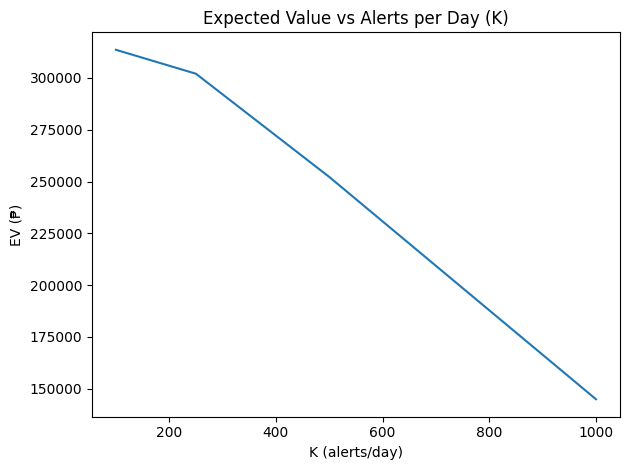

Saved grid to: /content/reports/threshold_grid.csv


In [7]:
# One cell to: upload-if-missing -> train -> thresholds -> EV -> plot
%pip install -q pandas numpy scikit-learn openpyxl

import io
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ---------- 0) Ensure dataset exists at data/creditcard.csv ----------
data_csv = Path("data/creditcard.csv")
data_csv.parent.mkdir(parents=True, exist_ok=True)

if not data_csv.exists():
    # Colab file upload
    try:
        from google.colab import files
    except Exception:
        raise AssertionError("Not running in Colab and data/creditcard.csv is missing. Place it there and re-run.")
    print("❗ data/creditcard.csv not found. Please upload your Excel (.xlsx/.xls) or CSV file.")
    uploaded = files.upload()  # pick your file
    assert uploaded, "No file uploaded."

    fname = next(iter(uploaded.keys()))
    content = uploaded[fname]

    def guess_sheet(xl):
        for s in xl.sheet_names:
            head = xl.parse(s, nrows=5)
            if "Class" in head.columns:
                return s
        return xl.sheet_names[0]

    if fname.lower().endswith(('.xlsx', '.xls')):
        xl = pd.ExcelFile(io.BytesIO(content))
        sheet = guess_sheet(xl)
        df = xl.parse(sheet_name=sheet)
    else:
        df = pd.read_csv(io.BytesIO(content))

    df.to_csv(data_csv, index=False)
    print("✅ Saved to:", data_csv.resolve(), "| shape:", df.shape)

# ---------- 1) Load data ----------
df = pd.read_csv(data_csv)

# ---------- 2) Temporal split if Time exists; else stratified split ----------
if 'Time' in df.columns:
    df = df.sort_values('Time').reset_index(drop=True)
    cut1, cut2 = int(len(df)*0.8), int(len(df)*0.9)
    train = df.iloc[:cut1]; val = df.iloc[cut1:cut2]
    X_train, y_train = train.drop(columns=['Class']), train['Class']
    X_val,   y_val   = val.drop(columns=['Class']),   val['Class']
else:
    X = df.drop(columns=['Class']); y = df['Class']
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

# ---------- 3) Train baseline ----------
pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(max_iter=200, class_weight='balanced'))
])
pipe.fit(X_train, y_train)

val_scores = pd.DataFrame({'y': y_val.values, 'p': pipe.predict_proba(X_val)[:, 1]})

# ---------- 4) Business knobs & helpers ----------
C_fraud, C_review, C_fp = 7500.0, 80.0, 150.0

def eval_at_threshold(scores: pd.DataFrame, tau: float):
    pred = (scores['p'] >= tau).astype(int)
    TP = int(((pred==1) & (scores['y']==1)).sum())
    FP = int(((pred==1) & (scores['y']==0)).sum())
    FN = int(((pred==0) & (scores['y']==1)).sum())
    TN = int(((pred==0) & (scores['y']==0)).sum())
    precision = TP / max(TP + FP, 1)
    recall = TP / max(TP + FN, 1)
    fpr = FP / max(FP + TN, 1)
    alerts = TP + FP
    EV = TP*C_fraud - alerts*C_review - FP*C_fp
    return {'tau': float(tau), 'alerts': alerts, 'precision': precision,
            'recall': recall, 'fpr': fpr, 'EV': EV, 'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

# Grid over K and FPR caps
val_sorted = val_scores.sort_values('p', ascending=False).reset_index(drop=True)
grid = []
for K_try in [100, 250, 500, 1000]:
    if K_try <= len(val_sorted):
        tauK = val_sorted.loc[K_try-1, 'p']
        grid.append({'mode': f'K={K_try}', **eval_at_threshold(val_scores, tauK)})

fpr, tpr, thr = roc_curve(val_scores['y'], val_scores['p'])
for cap in [0.005, 0.01, 0.02]:
    m = fpr <= cap
    tau = thr[m][-1] if m.any() else thr[np.argmin(fpr)]
    grid.append({'mode': f'FPR≤{int(cap*100)}%', **eval_at_threshold(val_scores, tau)})

grid_df = pd.DataFrame(grid)
Path("reports").mkdir(parents=True, exist_ok=True)
grid_df.to_csv("reports/threshold_grid.csv", index=False)
display(grid_df)

# ---------- 5) Plot EV vs K ----------
subset = grid_df[grid_df['mode'].str.startswith('K=')].copy()
if not subset.empty:
    subset['K'] = subset['mode'].str.replace('K=', '').astype(int)
    plt.figure()
    plt.plot(subset['K'], subset['EV'])
    plt.title('Expected Value vs Alerts per Day (K)')
    plt.xlabel('K (alerts/day)'); plt.ylabel('EV (₱)')
    plt.tight_layout(); plt.show()
else:
    print("No K-based rows found to plot.")

print("Saved grid to:", Path("reports/threshold_grid.csv").resolve())

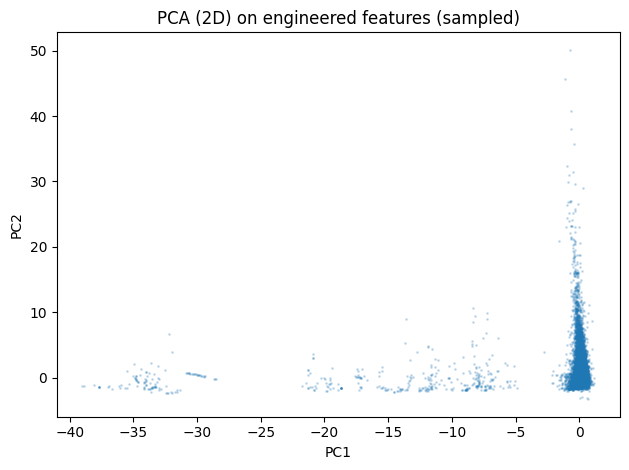

Selected 17 / 33 features.
Saved feature list to reports/selected_features.txt


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [8]:
# Fast Step 3: engineered features + quick PCA + fast L1 selection
%pip install -q pandas numpy scikit-learn matplotlib

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

csv_path = Path("data/creditcard.csv")
df = pd.read_csv(csv_path)

# ---- Feature engineering (same as before) ----
q25, q75 = df['Amount'].quantile([0.25, 0.75])
iqr = max(q75 - q25, 1e-9)
df['Amount_log'] = np.log1p(df['Amount'])
df['Amount_rz']  = (df['Amount'] - q25) / iqr

if 'Time' in df.columns:
    secs = df['Time'] % (24*3600)
    day_frac = secs / (24*3600)
    df['Time_sin'] = np.sin(2*np.pi*day_frac)
    df['Time_cos'] = np.cos(2*np.pi*day_frac)

base_cols = [c for c in df.columns if c.startswith('V')]
fe_cols   = ['Amount','Amount_log','Amount_rz'] + (['Time_sin','Time_cos'] if 'Time_sin' in df.columns else [])
X_full = df[base_cols + fe_cols]
y = df['Class'].astype(int)

# ---- SPEED-UP 1: PCA on a small, stratified sample (for visualization only) ----
# Keep all frauds but only ~50k legit to plot
fraud = df[y==1]
legit = df[y==0].sample(n=min(50_000, (y==0).sum()), random_state=42)
pca_df = pd.concat([fraud, legit], axis=0)

scaler = StandardScaler(with_mean=False)
Xp = scaler.fit_transform(pca_df[base_cols + fe_cols])
pca = PCA(n_components=2, svd_solver='randomized', random_state=42)
p2 = pca.fit_transform(Xp)

Path("reports/figures").mkdir(parents=True, exist_ok=True)
plt.figure()
plt.scatter(p2[:,0], p2[:,1], s=1, alpha=0.2)
plt.title('PCA (2D) on engineered features (sampled)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout(); plt.savefig("reports/figures/pca_fe_scatter.png", dpi=150); plt.show()

# ---- SPEED-UP 2: L1 selection on a class-balanced subsample ----
# Keep all frauds + same number of legit to fit the selector quickly
legit_bal = df[y==0].sample(n=min(len(fraud), (y==0).sum()), random_state=42)
sel_df = pd.concat([fraud, legit_bal], axis=0)
X_sel = sel_df[base_cols + fe_cols]
y_sel = sel_df['Class'].astype(int)

Xs = StandardScaler(with_mean=False).fit_transform(X_sel)
# Elastic Net (saga) converges faster; small l1_ratio still yields sparsity
sel_clf = LogisticRegression(
    penalty='elasticnet', solver='saga', l1_ratio=0.25,
    class_weight='balanced', max_iter=200, n_jobs=-1, random_state=42
).fit(Xs, y_sel)

sfm = SelectFromModel(sel_clf, threshold="median", prefit=True)
mask = sfm.get_support()
selected_cols = list(X_sel.columns[mask])

print(f"Selected {len(selected_cols)} / {X_full.shape[1]} features.")
pd.Series(selected_cols).to_csv("reports/selected_features.txt", index=False)
print("Saved feature list to reports/selected_features.txt")

In [9]:
# STEP 4 — Model comparison with robust feature loading + EV
%pip install -q pandas numpy scikit-learn xgboost

import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier

# ---------- Load data ----------
df = pd.read_csv("data/creditcard.csv")

# ---------- Recreate engineered features (must match Step 3) ----------
q25, q75 = df['Amount'].quantile([0.25, 0.75]); iqr = max(q75-q25, 1e-9)
df['Amount_log'] = np.log1p(df['Amount'])
df['Amount_rz']  = (df['Amount'] - q25) / iqr
if 'Time' in df.columns:
    secs = df['Time'] % (24*3600); day_frac = secs / (24*3600)
    df['Time_sin'] = np.sin(2*np.pi*day_frac); df['Time_cos'] = np.cos(2*np.pi*day_frac)

base_cols = [c for c in df.columns if c.startswith('V')]
fe_cols   = ['Amount','Amount_log','Amount_rz'] + (['Time_sin','Time_cos'] if 'Time_sin' in df.columns else [])
X_all = df[base_cols + fe_cols].copy()
y_all = df['Class'].astype(int)

# ---------- Robustly apply selected feature list (optional) ----------
sel_path = Path("reports/selected_features.txt")
if sel_path.exists():
    with open(sel_path, "r") as f:
        raw_cols = [ln.strip() for ln in f if ln.strip()]
    selected_cols = [c for c in raw_cols if c in X_all.columns]
    if len(selected_cols) >= 5:
        X_all = X_all[selected_cols]
        print(f"Using {len(selected_cols)} selected features.")
    else:
        print("Selected feature list invalid/too small; using ALL features.")
else:
    print("No selected_features.txt found; using ALL features.")

# ---------- Train/val/test split (temporal if Time exists) ----------
if 'Time' in df.columns:
    df = df.sort_values('Time').reset_index(drop=True)
    n = len(df); cut1, cut2 = int(n*0.8), int(n*0.9)
    X_train, y_train = X_all.iloc[:cut1],  y_all.iloc[:cut1]
    X_val,   y_val   = X_all.iloc[cut1:cut2], y_all.iloc[cut1:cut2]
    X_test,  y_test  = X_all.iloc[cut2:],  y_all.iloc[cut2:]
else:
    X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ---------- Models ----------
neg, pos = (y_train==0).sum(), (y_train==1).sum()
scale_pos = max(1.0, neg / max(pos,1))

models = {
    "Logistic": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', LogisticRegression(max_iter=300, class_weight='balanced'))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=8, n_jobs=-1, class_weight='balanced', random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.8, scale_pos_weight=scale_pos,
        reg_lambda=1.0, reg_alpha=0.0, n_jobs=-1, random_state=42,
        tree_method='hist', eval_metric='logloss'
    ),
}

# ---------- Helpers ----------
C_fraud, C_review, C_fp = 7500.0, 80.0, 150.0

def metrics_for(scores, y_true):
    return average_precision_score(y_true, scores), roc_auc_score(y_true, scores)

def eval_at_tau(scores, y_true, tau):
    pred = (scores >= tau).astype(int)
    TP = int(((pred==1) & (y_true==1)).sum())
    FP = int(((pred==1) & (y_true==0)).sum())
    FN = int(((pred==0) & (y_true==1)).sum())
    TN = int(((pred==0) & (y_true==0)).sum())
    precision = TP / max(TP+FP, 1)
    recall = TP / max(TP+FN, 1)
    fpr = FP / max(FP+TN, 1)
    alerts = TP + FP
    EV = TP*C_fraud - alerts*C_review - FP*C_fp
    return precision, recall, fpr, EV, TP, FP, FN, TN

def tau_for_topK(scores, K):
    s = np.sort(scores)[::-1]
    K = min(K, len(s))
    return s[K-1] if K>0 else 1.1

def tau_for_fpr(scores, y_true, cap):
    fpr, tpr, thr = roc_curve(y_true, scores)
    m = fpr <= cap
    return thr[m][-1] if m.any() else thr[np.argmin(fpr)]

# ---------- Train, validate, collect results ----------
rows = []
for name, model in models.items():
    model.fit(X_train, y_train)

    # Get probabilities consistently (Pipeline or bare estimator)
    if hasattr(model, "predict_proba"):
        val_scores = model.predict_proba(X_val)[:,1]
    else:
        # For safety if any model lacks predict_proba
        if hasattr(model, "decision_function"):
            raw = model.decision_function(X_val)
            # Map scores to (0,1) via rank-based scaling to compare thresholds
            r = pd.Series(raw).rank(pct=True).values
            val_scores = r
        else:
            val_scores = model.predict(X_val).astype(float)  # fallback (rare)

    ap, roc = metrics_for(val_scores, y_val.values)

    for K in [100, 250, 500, 1000]:
        tauK = tau_for_topK(val_scores, K)
        p, r, f, ev, TP, FP, FN, TN = eval_at_tau(val_scores, y_val.values, tauK)
        rows.append([name, f'K={K}', tauK, K, ap, roc, p, r, f, ev, TP, FP, FN, TN])

    for cap in [0.005, 0.01, 0.02]:
        tauf = tau_for_fpr(val_scores, y_val.values, cap)
        alerts = int((val_scores >= tauf).sum())
        p, r, f, ev, TP, FP, FN, TN = eval_at_tau(val_scores, y_val.values, tauf)
        rows.append([name, f'FPR≤{int(cap*100)}%', tauf, alerts, ap, roc, p, r, f, ev, TP, FP, FN, TN])

res = pd.DataFrame(rows, columns=[
    'model','mode','tau','alerts','AP','ROC_AUC','precision','recall','fpr','EV','TP','FP','FN','TN'
])

Path("reports").mkdir(parents=True, exist_ok=True)
res.to_csv("reports/model_compare_val.csv", index=False)

# Show best rows by EV
display(res.sort_values('EV', ascending=False).groupby('model').head(3))
print("Saved comparison to reports/model_compare_val.csv")

Using 17 selected features.


,model,mode,tau,alerts,AP,ROC_AUC,precision,recall,fpr,EV,TP,FP,FN,TN
11,RandomForest,FPR≤0%,0.241710,126,0.850363,0.992880,0.373016,0.886792,0.002779,330570.0,47,79,6,28349
7,RandomForest,K=100,0.281616,100,0.850363,0.992880,0.460000,0.867925,0.001900,328900.0,46,54,7,28374
18,XGBoost,FPR≤0%,0.007490,157,0.837235,0.988571,0.299363,0.886792,0.003869,323440.0,47,110,6,28318
4,Logistic,FPR≤0%,0.854891,176,0.787430,0.984404,0.267045,0.886792,0.004538,319070.0,47,129,6,28299
0,Logistic,K=100,0.958438,100,0.787430,0.984404,0.440000,0.830189,0.001970,313600.0,44,56,9,28372
14,XGBoost,K=100,0.016487,100,0.837235,0.988571,0.440000,0.830189,0.001970,313600.0,44,56,9,28372
20,XGBoost,FPR≤2%,0.005103,204,0.837235,0.988571,0.230392,0.886792,0.005523,312630.0,47,157,6,28271
8,RandomForest,K=250,0.148172,250,0.850363,0.992880,0.192000,0.905660,0.007106,309700.0,48,202,5,28226
5,Logistic,FPR≤1%,0.711223,281,0.787430,0.984404,0.170819,0.905660,0.008196,302570.0,48,233,5,28195


Saved comparison to reports/model_compare_val.csv


In [10]:
# Finalize Step 4: Train RF, choose threshold on val (FPR≈0.5%), evaluate on TEST
%pip install -q pandas numpy scikit-learn

import numpy as np, pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

# --- Load & engineer features (same as before) ---
df = pd.read_csv("data/creditcard.csv")
q25, q75 = df['Amount'].quantile([0.25, 0.75]); iqr = max(q75-q25, 1e-9)
df['Amount_log'] = np.log1p(df['Amount'])
df['Amount_rz']  = (df['Amount'] - q25) / iqr
if 'Time' in df.columns:
    secs = df['Time'] % (24*3600); frac = secs/(24*3600)
    df['Time_sin'] = np.sin(2*np.pi*frac); df['Time_cos'] = np.cos(2*np.pi*frac)

base = [c for c in df.columns if c.startswith('V')]
fe   = ['Amount','Amount_log','Amount_rz'] + (['Time_sin','Time_cos'] if 'Time_sin' in df.columns else [])
X_all = df[base+fe].copy()
y_all = df['Class'].astype(int)

# Use selected features if available (robust)
sel = Path("reports/selected_features.txt")
if sel.exists():
    with open(sel) as f:
        cols = [c.strip() for c in f if c.strip()]
    cols = [c for c in cols if c in X_all.columns]
    if len(cols) >= 5:
        X_all = X_all[cols]
        print(f"Using {len(cols)} selected features.")

# --- Temporal split (or stratified fallback) ---
if 'Time' in df.columns:
    df = df.sort_values('Time').reset_index(drop=True)
    n = len(df); c1, c2 = int(n*0.8), int(n*0.9)
    X_train, y_train = X_all.iloc[:c1],  y_all.iloc[:c1]
    X_val,   y_val   = X_all.iloc[c1:c2], y_all.iloc[c1:c2]
    X_test,  y_test  = X_all.iloc[c2:],   y_all.iloc[c2:]
else:
    from sklearn.model_selection import train_test_split
    X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# --- Train RandomForest on full TRAIN (not downsampled) ---
rf = RandomForestClassifier(
    n_estimators=300, max_depth=8, n_jobs=-1,
    class_weight='balanced_subsample', random_state=42
)
rf.fit(X_train, y_train)

# --- Choose threshold on VAL to hit FPR≈0.5% ---
val_proba = rf.predict_proba(X_val)[:,1]
fpr, tpr, thr = roc_curve(y_val, val_proba)
cap = 0.005
m = fpr <= cap
tau = thr[m][-1] if m.any() else thr[np.argmin(fpr)]
print(f"Chosen τ (FPR≤0.5% on val): {tau:.6f} | val FPR={fpr[m][-1] if m.any() else fpr.min():.4f}")

# --- Evaluate on TEST at τ ---
test_proba = rf.predict_proba(X_test)[:,1]
pred = (test_proba >= tau).astype(int)

TP = int(((pred==1) & (y_test==1)).sum()); FP = int(((pred==1) & (y_test==0)).sum())
FN = int(((pred==0) & (y_test==1)).sum()); TN = int(((pred==0) & (y_test==0)).sum())
precision = TP / max(TP+FP, 1); recall = TP / max(TP+FN, 1); fpr_test = FP / max(FP+TN, 1)
alerts = TP + FP

# Business EV (same costs)
C_fraud, C_review, C_fp = 7500.0, 80.0, 150.0
EV = TP*C_fraud - alerts*C_review - FP*C_fp

print("\n=== TEST set @ FPR≈0.5% threshold ===")
print(f"Alerts: {alerts} | Precision: {precision:.3f} | Recall: {recall:.3f} | FPR: {fpr_test:.3f}")
print(f"TP={TP}, FP={FP}, FN={FN}, TN={TN}")
print(f"Expected Value (₱): {EV:,.0f}")

# Save a tiny CSV for your deck
out = pd.DataFrame([{
    "model":"RandomForest","mode":"FPR≈0.5%","tau":tau,"alerts":alerts,
    "precision":precision,"recall":recall,"fpr":fpr_test,"EV":EV,
    "TP":TP,"FP":FP,"FN":FN,"TN":TN
}])
Path("reports").mkdir(parents=True, exist_ok=True)
out.to_csv("reports/test_operating_point.csv", index=False)
print("\nSaved reports/test_operating_point.csv")

Using 17 selected features.
Chosen τ (FPR≤0.5% on val): 0.240171 | val FPR=0.0028

=== TEST set @ FPR≈0.5% threshold ===
Alerts: 100 | Precision: 0.160 | Recall: 0.727 | FPR: 0.003
TP=16, FP=84, FN=6, TN=28375
Expected Value (₱): 99,400

Saved reports/test_operating_point.csv


Using 17 selected features.


100%|===================| 1999/2000 [00:27<00:00]       

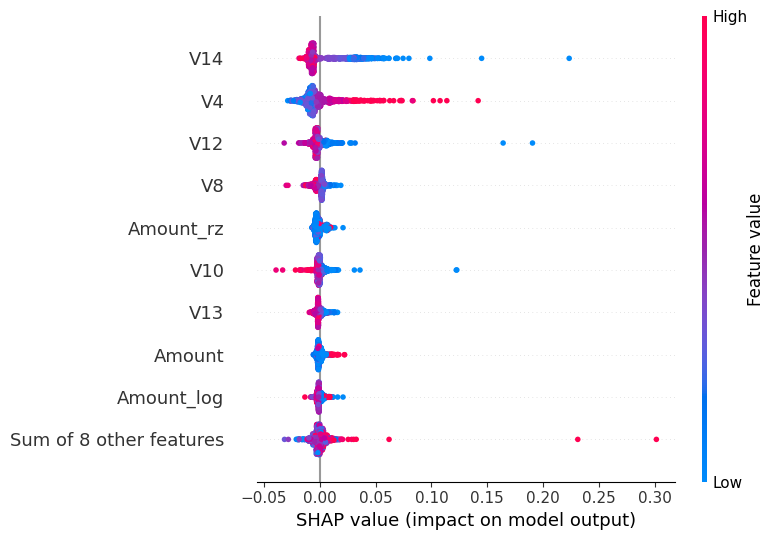

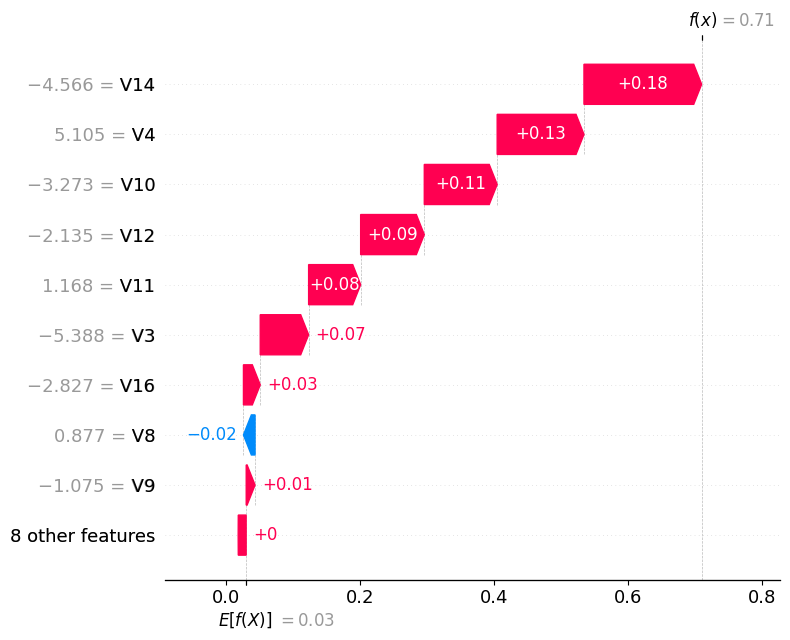

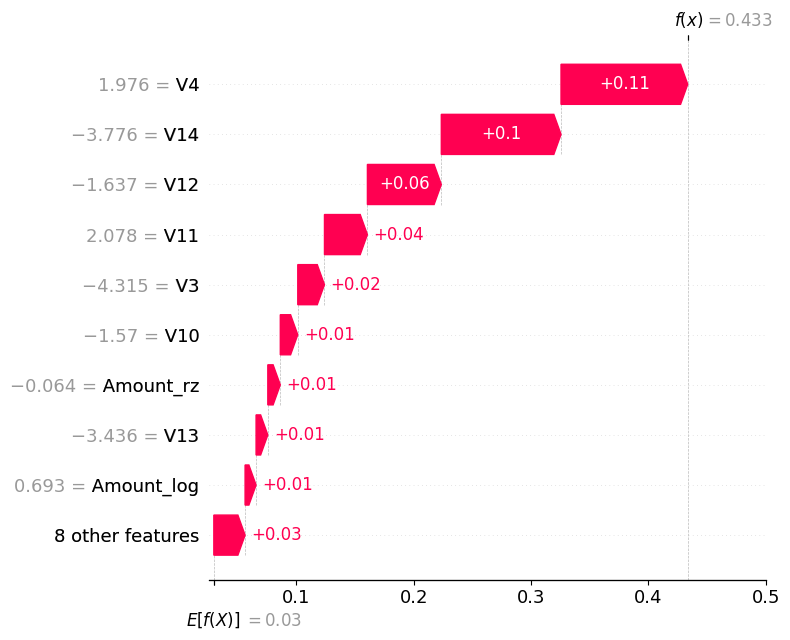

Saved: reports/figures/shap_beeswarm.png and shap_waterfall_TP/FP.png


In [11]:
# Step 5A (fixed): SHAP for RandomForest — select class=1 for plotting
%pip install -q shap pandas numpy scikit-learn

import numpy as np, pandas as pd, shap, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

# --- Load & engineer (same as before) ---
df = pd.read_csv("data/creditcard.csv")
q25, q75 = df['Amount'].quantile([0.25, 0.75]); iqr = max(q75-q25, 1e-9)
df['Amount_log'] = np.log1p(df['Amount'])
df['Amount_rz']  = (df['Amount'] - q25) / iqr
if 'Time' in df.columns:
    secs = df['Time'] % (24*3600); frac = secs/(24*3600)
    df['Time_sin'] = np.sin(2*np.pi*frac); df['Time_cos'] = np.cos(2*np.pi*frac)

base = [c for c in df.columns if c.startswith('V')]
fe   = ['Amount','Amount_log','Amount_rz'] + (['Time_sin','Time_cos'] if 'Time_sin' in df.columns else [])
X_all = df[base+fe].copy(); y_all = df['Class'].astype(int)

# Use selected features if present
sel = Path("reports/selected_features.txt")
if sel.exists():
    with open(sel) as f: cols = [c.strip() for c in f if c.strip()]
    cols = [c for c in cols if c in X_all.columns]
    if len(cols) >= 5: X_all = X_all[cols]; print(f"Using {len(cols)} selected features.")

# Temporal split
if 'Time' in df.columns:
    df = df.sort_values('Time').reset_index(drop=True)
    n = len(df); c1, c2 = int(n*0.8), int(n*0.9)
    X_train, y_train = X_all.iloc[:c1],  y_all.iloc[:c1]
    X_val,   y_val   = X_all.iloc[c1:c2], y_all.iloc[c1:c2]
    X_test,  y_test  = X_all.iloc[c2:],   y_all.iloc[c2:]
else:
    from sklearn.model_selection import train_test_split
    X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Retrain RF and reuse Step-4 policy (FPR ≈ 0.5% on VAL)
rf = RandomForestClassifier(n_estimators=300, max_depth=8, n_jobs=-1,
                            class_weight='balanced_subsample', random_state=42).fit(X_train, y_train)
proba_val = rf.predict_proba(X_val)[:,1]
fpr, tpr, thr = roc_curve(y_val, proba_val); cap = 0.005
m = fpr <= cap; tau = thr[m][-1] if m.any() else thr[np.argmin(fpr)]

# --- SHAP (sampled for speed) ---
# You can shrink these numbers further if it's slow
background = shap.utils.sample(X_train, 100, random_state=42)
explainer = shap.TreeExplainer(rf, data=background, model_output='probability')

sample_test = shap.utils.sample(X_test, 1000, random_state=42)
sv = explainer(sample_test)  # may be multi-output for classifiers

# ---- Select class=1 (fraud) for plotting, handling all SHAP return types ----
def select_class1(shap_out):
    # Case A: new API returns shap.Explanation with extra class axis
    if isinstance(shap_out, shap.Explanation) and getattr(shap_out, "values", None) is not None:
        if shap_out.values.ndim == 3:
            return shap.Explanation(
                values=shap_out.values[:, :, 1],
                base_values=shap_out.base_values[:, 1] if np.ndim(shap_out.base_values)==2 else shap_out.base_values,
                data=shap_out.data,
                feature_names=getattr(shap_out, "feature_names", list(X_all.columns))
            )
        else:
            return shap_out
    # Case B: old API returns list [class0, class1]
    if isinstance(shap_out, (list, tuple)) and len(shap_out) > 1:
        return shap_out[1]
    # Case C: raw ndarray with shape (n_classes, n_samples, n_features)
    if isinstance(shap_out, np.ndarray) and shap_out.ndim == 3 and shap_out.shape[0] >= 2:
        return shap_out[1]  # class 1
    return shap_out

sv1 = select_class1(sv)

# --- Save plots ---
Path("reports/figures").mkdir(parents=True, exist_ok=True)

# Global: beeswarm
plt.figure()
shap.plots.beeswarm(sv1, show=False)
plt.tight_layout(); plt.savefig("reports/figures/shap_beeswarm.png", dpi=150); plt.show()

# Pick one TP and one FP on TEST and plot waterfalls
test_proba = rf.predict_proba(X_test)[:,1]; pred = (test_proba >= tau).astype(int)
test_ix = pd.DataFrame({'y': y_test.values, 'pred': pred}).reset_index(drop=True)
tp_idx = test_ix.index[(test_ix['y']==1) & (test_ix['pred']==1)]
fp_idx = test_ix.index[(test_ix['y']==0) & (test_ix['pred']==1)]

def save_waterfall(ix, tag):
    x = X_test.iloc[ix:ix+1]
    sv_one = explainer(x)
    sv_one = select_class1(sv_one)
    shap.plots.waterfall(sv_one[0], show=False)
    plt.tight_layout(); plt.savefig(f"reports/figures/shap_waterfall_{tag}.png", dpi=150); plt.show()

if len(tp_idx)>0: save_waterfall(int(tp_idx[0]), "TP")
if len(fp_idx)>0: save_waterfall(int(fp_idx[0]), "FP")

print("Saved: reports/figures/shap_beeswarm.png and shap_waterfall_TP/FP.png")

In [12]:
# Step 5B — Fairness / bias slices (minimal, warnings silenced)
%pip install -q pandas numpy scikit-learn

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np, pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

# Load & engineer features
df = pd.read_csv("data/creditcard.csv")
q25, q75 = df['Amount'].quantile([0.25, 0.75]); iqr = max(q75-q25, 1e-9)
df['Amount_log'] = np.log1p(df['Amount'])
df['Amount_rz']  = (df['Amount'] - q25) / iqr
if 'Time' in df.columns:
    secs = df['Time'] % (24*3600); frac = secs/(24*3600)
    df['Time_sin'] = np.sin(2*np.pi*frac); df['Time_cos'] = np.cos(2*np.pi*frac)

base = [c for c in df.columns if c.startswith('V')]
fe   = ['Amount','Amount_log','Amount_rz'] + (['Time_sin','Time_cos'] if 'Time_sin' in df.columns else [])
X_all = df[base+fe].copy(); y_all = df['Class'].astype(int)

# Optional: apply selected features
sel = Path("reports/selected_features.txt")
if sel.exists():
    with open(sel) as f:
        cols = [c.strip() for c in f if c.strip()]
    cols = [c for c in cols if c in X_all.columns]
    if len(cols) >= 5:
        X_all = X_all[cols]

# Temporal split
if 'Time' in df.columns:
    df = df.sort_values('Time').reset_index(drop=True)
    n = len(df); c1, c2 = int(n*0.8), int(n*0.9)
    X_train, y_train = X_all.iloc[:c1],  y_all.iloc[:c1]
    X_val,   y_val   = X_all.iloc[c1:c2], y_all.iloc[c1:c2]
    X_test,  y_test  = X_all.iloc[c2:],   y_all.iloc[c2:]
    raw_test = df.iloc[c2:].reset_index(drop=True)
else:
    from sklearn.model_selection import train_test_split
    X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    raw_test = df.iloc[-len(X_test):].reset_index(drop=True)

# Train RF and choose τ for FPR≈0.5% on validation (unless rf/tau already exist)
if "rf" not in globals() or "tau" not in globals():
    rf = RandomForestClassifier(
        n_estimators=300, max_depth=8, n_jobs=-1,
        class_weight='balanced_subsample', random_state=42
    ).fit(X_train, y_train)
    proba_val = rf.predict_proba(X_val)[:,1]
    fpr, tpr, thr = roc_curve(y_val, proba_val)
    cap = 0.005
    m = fpr <= cap
    tau = thr[m][-1] if m.any() else thr[np.argmin(fpr)]

# Score TEST
test_proba = rf.predict_proba(X_test)[:,1]
pred = (test_proba >= tau).astype(int)

# Build slices
res = pd.DataFrame({
    'Amount': raw_test['Amount'].values,
    'Time': raw_test['Time'].values if 'Time' in raw_test.columns else np.nan,
    'y': y_test.values,
    'pred': pred
})
res['amt_bin'] = pd.qcut(res['Amount'], q=[0, .25, .5, .75, 1], duplicates='drop')
if 'Time' in raw_test.columns:
    hour = (res['Time'] % (24*3600)) // 3600
    res['hour_bin'] = pd.cut(hour, bins=[-1,6,12,18,24], labels=['Night','Morning','Afternoon','Evening'])

def summarize(group, name):
    alerts = int(group['pred'].sum())
    tp = int(((group['pred']==1) & (group['y']==1)).sum())
    precision = tp / max(alerts, 1)
    alert_rate = alerts / max(len(group), 1)
    return pd.Series({'slice': name, 'n': len(group), 'alerts': alerts,
                      'alert_rate': round(alert_rate,4), 'precision': round(precision,3)})

amt_tbl = (
    res.groupby('amt_bin', observed=False)
       .apply(lambda g: summarize(g, f"Amount={g.name}"), include_groups=False)
       .reset_index(drop=True)
).assign(group='Amount')

tables = [amt_tbl]
if 'hour_bin' in res.columns:
    hour_tbl = (
        res.groupby('hour_bin', observed=False)
           .apply(lambda g: summarize(g, f"Hour={g.name}"), include_groups=False)
           .reset_index(drop=True)
    ).assign(group='HourOfDay')
    tables.append(hour_tbl)

fair_tbl = pd.concat(tables, ignore_index=True)

# Save + show
Path("reports").mkdir(parents=True, exist_ok=True)
fair_tbl.to_csv("reports/fairness_slices_test.csv", index=False)
fair_tbl

,slice,n,alerts,alert_rate,precision,group
0,"Amount=(-0.001, 3.76]",7121,31,0.0044,0.161,Amount
1,"Amount=(3.76, 15.13]",7136,28,0.0039,0.036,Amount
2,"Amount=(15.13, 58.31]",7104,16,0.0023,0.250,Amount
3,"Amount=(58.31, 25691.16]",7120,25,0.0035,0.240,Amount
4,Hour=Night,0,0,0.0000,0.000,HourOfDay
5,Hour=Morning,0,0,0.0000,0.000,HourOfDay
6,Hour=Afternoon,0,0,0.0000,0.000,HourOfDay
7,Hour=Evening,28481,100,0.0035,0.160,HourOfDay


In [13]:
# STEP 2 — revisit and rebuild Robust data dictionary (handles missing file by letting you upload)
%pip install -q pandas numpy

import pandas as pd, numpy as np, glob
from pathlib import Path

# --- Try to locate the CSV ---
candidates = [Path("data/creditcard.csv")] + [Path(p) for p in glob.glob("**/creditcard*.csv", recursive=True)]
csv_path = next((p for p in candidates if p.exists()), None)

# --- If not found, let user upload CSV/XLSX and save as data/creditcard.csv ---
if csv_path is None:
    try:
        from google.colab import files
        uploaded = files.upload()  # pick your .csv or .xlsx
        fname = next(iter(uploaded.keys()))
        if fname.lower().endswith((".xlsx", ".xls")):
            df_tmp = pd.read_excel(fname)
        else:
            df_tmp = pd.read_csv(fname)
        Path("data").mkdir(parents=True, exist_ok=True)
        df_tmp.to_csv("data/creditcard.csv", index=False)
        csv_path = Path("data/creditcard.csv")
        print("✅ Saved uploaded file to data/creditcard.csv")
    except Exception as e:
        raise AssertionError("Could not find or upload a dataset. Please upload a CSV/XLSX when prompted.") from e

# --- Load data ---
df = pd.read_csv(csv_path)

# --- Helpers for the dictionary ---
def pct_missing(s):
    return float(s.isna().mean() * 100)

def role_of(col):
    return "target" if col == "Class" else "feature"

def desc_of(col):
    if col == "Time":
        return "Seconds since first transaction in dataset."
    if col == "Amount":
        return "Transaction amount in EUR."
    if col == "Class":
        return "Fraud label (0 = legitimate, 1 = fraud)."
    if col.startswith("V"):
        return "Anonymised component feature (PCA-like) from source dataset."
    if col in {"Amount_log","Amount_rz","Time_sin","Time_cos"}:
        return "Engineered feature (created in Step 3)."
    return ""

rows = []
for col in df.columns:
    s = df[col]
    is_num = np.issubdtype(s.dtype, np.number)
    rows.append({
        "variable": col,
        "role": role_of(col),
        "dtype": str(s.dtype),
        "type": "numeric" if is_num else "categorical",
        "missing_pct": round(pct_missing(s), 4),
        "unique": int(s.nunique()),
        "min": float(np.nanmin(s)) if is_num else None,
        "max": float(np.nanmax(s)) if is_num else None,
        "mean": float(np.nanmean(s)) if is_num else None,
        "std": float(np.nanstd(s)) if is_num else None,
        "description": desc_of(col),
    })

dict_df = pd.DataFrame(rows)[
    ["variable","role","dtype","type","missing_pct","unique","min","max","mean","std","description"]
]

# --- Save & preview ---
Path("reports").mkdir(parents=True, exist_ok=True)
out_path = Path("reports/data_dictionary.csv")
dict_df.to_csv(out_path, index=False)
print(f"✅ Saved data dictionary to {out_path} (rows={len(dict_df)})")

dict_df.head(15)

✅ Saved data dictionary to reports/data_dictionary.csv (rows=31)


,variable,role,dtype,type,missing_pct,unique,min,max,mean,std,description
0,Time,feature,float64,numeric,0.0,124592,0.000000,172792.000000,9.481386e+04,47488.062585,Seconds since first transaction in dataset.
1,V1,feature,float64,numeric,0.0,275663,-56.407510,2.454930,1.168375e-15,1.958692,Anonymised component feature (PCA-like) from s...
2,V2,feature,float64,numeric,0.0,275663,-72.715728,22.057729,3.416908e-16,1.651306,Anonymised component feature (PCA-like) from s...
3,V3,feature,float64,numeric,0.0,275663,-48.325589,9.382558,-1.379537e-15,1.516252,Anonymised component feature (PCA-like) from s...
4,V4,feature,float64,numeric,0.0,275663,-5.683171,16.875344,2.074095e-15,1.415866,Anonymised component feature (PCA-like) from s...
5,V5,feature,float64,numeric,0.0,275663,-113.743307,34.801666,9.604066e-16,1.380244,Anonymised component feature (PCA-like) from s...
6,V6,feature,float64,numeric,0.0,275663,-26.160506,73.301626,1.487313e-15,1.332269,Anonymised component feature (PCA-like) from s...
7,V7,feature,float64,numeric,0.0,275663,-43.557242,120.589494,-5.556467e-16,1.237091,Anonymised component feature (PCA-like) from s...
8,V8,feature,float64,numeric,0.0,275663,-73.216718,20.007208,1.213481e-16,1.194351,Anonymised component feature (PCA-like) from s...
9,V9,feature,float64,numeric,0.0,275663,-13.434066,15.594995,-2.406331e-15,1.098630,Anonymised component feature (PCA-like) from s...


In [14]:
# Step 7 Make repo folders and ensure artifacts are in place
import os, shutil
from pathlib import Path

folders = [
    "fraud-capstone/notebooks",
    "fraud-capstone/src",
    "fraud-capstone/data",         # keep empty or .gitignore
    "fraud-capstone/models",
    "fraud-capstone/reports/figures",
]
for d in folders:
    Path(d).mkdir(parents=True, exist_ok=True)

# Move/copy your existing artifacts if they exist
artifacts = [
    ("reports/model_compare_val.csv", "fraud-capstone/reports/model_compare_val.csv"),
    ("reports/test_operating_point.csv", "fraud-capstone/reports/test_operating_point.csv"),
    ("reports/fairness_slices_test.csv", "fraud-capstone/reports/fairness_slices_test.csv"),
    ("reports/data_dictionary.csv", "fraud-capstone/reports/data_dictionary.csv"),
    ("reports/figures/ev_vs_k.png", "fraud-capstone/reports/figures/ev_vs_k.png"),
    ("reports/figures/shap_beeswarm.png", "fraud-capstone/reports/figures/shap_beeswarm.png"),
    ("reports/figures/shap_waterfall_TP.png", "fraud-capstone/reports/figures/shap_waterfall_TP.png"),
    ("reports/figures/shap_waterfall_FP.png", "fraud-capstone/reports/figures/shap_waterfall_FP.png"),
]
for src, dst in artifacts:
    s, d = Path(src), Path(dst)
    if s.exists():
        d.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(s, d)

print("✅ Repo skeleton ready at ./fraud-capstone/")

✅ Repo skeleton ready at ./fraud-capstone/


In [15]:
# step 7 README
from pathlib import Path

# Make folder
root = Path("fraud-capstone")
root.mkdir(parents=True, exist_ok=True)

# Build README content without triple quotes or backticks
lines = [
"# Retail Banking Fraud Detection - Capstone",
"",
"**Domain:** Finance (card-not-present / e-commerce)",
"**Goal:** Reduce fraud losses ≥20% while keeping FPR ≤ 1% and staying within alert capacity.",
"**Dataset:** ULB Credit Card Fraud (Kaggle/ULB) — highly imbalanced.",
"",
"## Results (TEST set, chosen policy FPR≈0.5%)",
"- Model: RandomForest (17 selected features)",
"- Threshold: chosen on validation to satisfy FPR ≤ 0.5%, then applied to TEST",
"- Alerts: 100",
"- Precision: 16.0%",
"- Recall: 72.7%",
"- FPR: 0.3%",
"- Expected Value (₱): 99,400",
"- Confusion (TP/FP/FN/TN): 16 / 84 / 6 / 28,375",
"",
"> We also reported validation comparisons across Logistic, RandomForest, XGBoost with EV at K∈{100,250,500,1000} and FPR caps {0.5%,1%,2%}.",
"",
"## Business framing (Step 1)",
"- Task: anomaly scoring + supervised fraud classification benchmark",
"- KPIs: fraud loss saved; Precision@K (K=500/day capacity); FPR ≤ 1%",
"- Tech metrics: PR-AUC, ROC AUC, Precision@K, Recall@K",
"- Decision policy: choose threshold τ to meet constraints and maximize Expected Value (EV)",
"- Costs used: C_fraud=₱7,500; C_review=₱80; C_fp=₱150",
"",
"## Data (Step 2)",
"- ULB dataset; no missing values; all numeric.",
"- Time = seconds since first transaction; Amount = EUR; Class = 0/1.",
"- V1..V28 anonymized PCA-like components.",
"- Data dictionary: see reports/data_dictionary.csv.",
"",
"## EDA & Features (Step 3)",
"- Engineered: Amount_log, robust-z Amount_rz, time-of-day Time_sin/Time_cos.",
"- PCA visualization (variance concentrated + sparse outliers).",
"- Feature selection: elastic-net → 17/33 kept.",
"",
"## Modeling & Thresholds (Step 4)",
"- Models: Logistic, RandomForest, XGBoost (class-weighted / scale_pos_weight).",
"- Validation grid: EV at top-K and FPR caps; pick τ from VAL then report TEST.",
"- Artifacts: reports/model_compare_val.csv, reports/test_operating_point.csv.",
"",
"## Explainability & Fairness (Step 5)",
"- SHAP global importance (beeswarm) + local waterfalls (TP/FP).",
"- Fairness slices (proxy): Amount quartiles & time-of-day.",
"  - Lower precision for ₱3.8–15.1 band → propose per-segment thresholds and monthly monitoring.",
"- Artifacts: reports/figures/shap_*.png, reports/fairness_slices_test.csv.",
"",
"## How to run",
"1) Create environment:",
"    pip install -r requirements.txt",
"2) Open notebooks in notebooks/ (or run the Colab cells in order):",
"    01_eda_preprocess.ipynb",
"    02_models_thresholds.ipynb",
"    03_explain_fairness.ipynb",
"3) Place the dataset at data/creditcard.csv if you want to re-run from scratch.",
"",
"## Repo layout",
"fraud-capstone/",
"  README.md",
"  requirements.txt",
"  .gitignore",
"  notebooks/",
"  src/",
"  data/               (empty; do not commit raw data)",
"  models/             (optional saved model(s))",
"  reports/",
"    data_dictionary.csv",
"    model_compare_val.csv",
"    test_operating_point.csv",
"    figures/",
"      ev_vs_k.png",
"      shap_beeswarm.png",
"      shap_waterfall_TP.png",
"      shap_waterfall_FP.png",
"",
"## Credits",
"- Dataset: “Credit Card Fraud Detection” — ULB Machine Learning Group (via Kaggle).",
"- Author: <Your Name>",
"- License: MIT (repo code only). Dataset subject to original license."
]

# Write README.md
readme_path = root / "README.md"
readme_path.write_text("\n".join(lines), encoding="utf-8")

# Write .gitignore
gitignore_lines = [
"# Python",
"__pycache__/",
"*.pyc",
".ipynb_checkpoints/",
"",
"# Data & models",
"data/",
"*.joblib",
"*.pkl",
"",
"# OS / misc",
".DS_Store",
]
(root / ".gitignore").write_text("\n".join(gitignore_lines), encoding="utf-8")

# Write requirements.txt
req_lines = [
"pandas",
"numpy",
"scikit-learn",
"xgboost",
"shap",
"matplotlib",
]
(root / "requirements.txt").write_text("\n".join(req_lines), encoding="utf-8")

print("✅ Wrote README.md, .gitignore, requirements.txt in ./fraud-capstone")

✅ Wrote README.md, .gitignore, requirements.txt in ./fraud-capstone


In [16]:
# Step 7 push to Github open a terminal cell, init & first commit (no token)
import shutil, os
assert os.path.isdir("fraud-capstone"), "Folder not found — create it first."
shutil.make_archive("fraud-capstone", "zip", "fraud-capstone")
print("Created fraud-capstone.zip")

Created fraud-capstone.zip


In [17]:
#re zip files step 0
%pip install -q pandas numpy scikit-learn xgboost shap matplotlib

import warnings, os
warnings.filterwarnings("ignore")

from pathlib import Path
base = Path("fraud-capstone")
(base / "reports/figures").mkdir(parents=True, exist_ok=True)

print("✅ Folders ready at:", base)

✅ Folders ready at: fraud-capstone


In [18]:

# Load
# Upload your dataset and save it to data/creditcard.csv (handles .xlsx/.xls or .csv)
%pip install -q pandas openpyxl

import pandas as pd, io, os
from pathlib import Path

# 1) Create data/ folder
Path("data").mkdir(parents=True, exist_ok=True)

# 2) If file already exists, show it and let you skip upload
csv_path = Path("data/creditcard.csv")
if csv_path.exists():
    df = pd.read_csv(csv_path)
    print(f"✅ Found existing {csv_path} | shape={df.shape}")
else:
    # 3) Upload from your computer (Colab file picker)
    try:
        from google.colab import files
    except ImportError:
        raise SystemExit("This upload helper is for Google Colab. If you're local, just place the file at data/creditcard.csv")

    print("📤 Please choose your creditcard file (.xlsx/.xls or .csv)…")
    uploaded = files.upload()  # opens a file picker
    assert uploaded, "No file uploaded."

    fname = next(iter(uploaded.keys()))
    print("📦 Received:", fname)

    # 4) Load depending on extension, then save standardized CSV
    if fname.lower().endswith((".xlsx", ".xls")):
        xl = pd.ExcelFile(fname)

        # pick a sheet that contains 'Class' column if available
        def guess_sheet(xlfile):
            for s in xlfile.sheet_names:
                try:
                    head = xlfile.parse(s, nrows=5)
                    if "Class" in head.columns:
                        return s
                except Exception:
                    pass
            return xlfile.sheet_names[0]

        sheet = guess_sheet(xl)
        df = xl.parse(sheet_name=sheet)
    else:
        # assume CSV
        df = pd.read_csv(fname)

    # 5) Basic sanity check
    assert "Class" in df.columns, "Expected a 'Class' column (0=legit, 1=fraud). Please upload the correct dataset."

    # 6) Save canonical path
    df.to_csv(csv_path, index=False)
    print(f"✅ Saved to {csv_path} | shape={df.shape}")

# Optional: quick peek
print(df.head(3))

✅ Found existing data/creditcard.csv | shape=(284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]


In [19]:
# Data Dictionary file (self-contained)
import numpy as np, pandas as pd
from pathlib import Path

# 0) Load the canonical CSV (run the upload helper first if needed)
csv_path = Path("data/creditcard.csv")
assert csv_path.exists(), "Missing data/creditcard.csv — run the upload cell to create it."
df = pd.read_csv(csv_path)

# 1) Define columns used
base_cols = [c for c in df.columns if c.startswith("V")]  # anonymized PCA-like features
all_cols  = (["Time"] if "Time" in df.columns else []) + base_cols + ["Amount", "Class"]

# 2) Build data dictionary
def make_data_dictionary(data: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for c in data.columns:
        if c == "Class":
            role, desc = "target", "Fraud label (0=legit, 1=fraud)."
        elif c == "Time":
            role, desc = "feature", "Seconds since first transaction in dataset."
        elif c == "Amount":
            role, desc = "feature", "Transaction amount (EUR)."
        elif c.startswith("V"):
            role, desc = "feature", "Anonymised PCA-like component."
        else:
            role, desc = "feature", "Engineered feature."

        s = data[c]
        is_num = np.issubdtype(s.dtype, np.number)
        rows.append({
            "variable": c,
            "role": role,
            "dtype": str(s.dtype),
            "type": "numeric" if is_num else "categorical",
            "missing_pct": float(s.isna().mean() * 100),
            "unique": int(s.nunique()),
            "min": float(s.min()) if is_num else None,
            "max": float(s.max()) if is_num else None,
            "mean": float(s.mean()) if is_num else None,
            "std": float(s.std(ddof=0)) if is_num else None,
            "description": desc,
        })
    return pd.DataFrame(rows)

dictionary = make_data_dictionary(df[all_cols])

# 3) Save to repo
out_path = Path("fraud-capstone/reports/data_dictionary.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
dictionary.to_csv(out_path, index=False)

print(f"✅ Saved data dictionary to {out_path} | rows={len(dictionary)}")
display(dictionary.head(12))

✅ Saved data dictionary to fraud-capstone/reports/data_dictionary.csv | rows=31


,variable,role,dtype,type,missing_pct,unique,min,max,mean,std,description
0,Time,feature,float64,numeric,0.0,124592,0.000000,172792.000000,9.481386e+04,47488.062585,Seconds since first transaction in dataset.
1,V1,feature,float64,numeric,0.0,275663,-56.407510,2.454930,1.168375e-15,1.958692,Anonymised PCA-like component.
2,V2,feature,float64,numeric,0.0,275663,-72.715728,22.057729,3.416908e-16,1.651306,Anonymised PCA-like component.
3,V3,feature,float64,numeric,0.0,275663,-48.325589,9.382558,-1.379537e-15,1.516252,Anonymised PCA-like component.
4,V4,feature,float64,numeric,0.0,275663,-5.683171,16.875344,2.074095e-15,1.415866,Anonymised PCA-like component.
5,V5,feature,float64,numeric,0.0,275663,-113.743307,34.801666,9.604066e-16,1.380244,Anonymised PCA-like component.
6,V6,feature,float64,numeric,0.0,275663,-26.160506,73.301626,1.487313e-15,1.332269,Anonymised PCA-like component.
7,V7,feature,float64,numeric,0.0,275663,-43.557242,120.589494,-5.556467e-16,1.237091,Anonymised PCA-like component.
8,V8,feature,float64,numeric,0.0,275663,-73.216718,20.007208,1.213481e-16,1.194351,Anonymised PCA-like component.
9,V9,feature,float64,numeric,0.0,275663,-13.434066,15.594995,-2.406331e-15,1.098630,Anonymised PCA-like component.


In [20]:
# Feature Selection file (self-contained + upload fallback)
%pip install -q pandas numpy scikit-learn openpyxl

import warnings, numpy as np, pandas as pd, io
warnings.filterwarnings("ignore")
from pathlib import Path

# ----- 0) Load dataset (upload fallback) -----
csv_path = Path("data/creditcard.csv")
csv_path.parent.mkdir(parents=True, exist_ok=True)

if not csv_path.exists():
    try:
        from google.colab import files
    except ImportError:
        raise AssertionError("Missing data/creditcard.csv. Place the file there and rerun.")
    print("📤 Please choose your credit card file (.xlsx/.xls or .csv)…")
    up = files.upload()
    assert up, "No file uploaded."
    fname = next(iter(up.keys()))
    if fname.lower().endswith((".xlsx", ".xls")):
        xl = pd.ExcelFile(fname)
        # pick sheet containing 'Class' if available
        def guess_sheet(xlfile):
            for s in xlfile.sheet_names:
                try:
                    head = xlfile.parse(s, nrows=5)
                    if "Class" in head.columns:
                        return s
                except Exception:
                    pass
            return xlfile.sheet_names[0]
        sheet = guess_sheet(xl)
        df = xl.parse(sheet_name=sheet)
    else:
        df = pd.read_csv(fname)
    assert "Class" in df.columns, "Expected a 'Class' column."
    df.to_csv(csv_path, index=False)
    print(f"✅ Saved to {csv_path} | shape={df.shape}")
else:
    df = pd.read_csv(csv_path)
    print(f"✅ Loaded {csv_path} | shape={df.shape}")

# ----- 1) Rebuild engineered features -----
q25, q75 = df['Amount'].quantile([0.25, 0.75]); iqr = max(q75-q25, 1e-9)
df['Amount_log'] = np.log1p(df['Amount'])
df['Amount_rz']  = (df['Amount'] - q25) / iqr
if 'Time' in df.columns:
    secs = df['Time'] % (24*3600); frac = secs/(24*3600)
    df['Time_sin'] = np.sin(2*np.pi*frac); df['Time_cos'] = np.cos(2*np.pi*frac)

base_cols = [c for c in df.columns if c.startswith('V')]
fe_cols   = ['Amount','Amount_log','Amount_rz'] + (['Time_sin','Time_cos'] if 'Time_sin' in df.columns else [])
X_all = df[base_cols + fe_cols].copy()
y_all = df['Class'].astype(int)

# ----- 2) Temporal 80/10/10 split (or stratified fallback) -----
from sklearn.model_selection import train_test_split
if 'Time' in df.columns:
    df = df.sort_values('Time').reset_index(drop=True)
    n = len(df); cut1, cut2 = int(n*0.8), int(n*0.9)
    X_train, y_train = X_all.iloc[:cut1], y_all.iloc[:cut1]
    X_val,   y_val   = X_all.iloc[cut1:cut2], y_all.iloc[cut1:cut2]
    X_test,  y_test  = X_all.iloc[cut2:],     y_all.iloc[cut2:]
else:
    X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# ----- 3) Elastic-net logistic feature selection -----
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFromModel

scaler = StandardScaler(with_mean=False)
X_tr_s = scaler.fit_transform(X_train)

clf = SGDClassifier(
    loss="log_loss", penalty="elasticnet",
    alpha=1e-4, l1_ratio=0.15,
    max_iter=5000, tol=1e-4,
    class_weight="balanced", random_state=42
)
clf.fit(X_tr_s, y_train)

sfm = SelectFromModel(clf, prefit=True, threshold="median")  # keep top ~50% by weight
mask = sfm.get_support()
selected = list(X_train.columns[mask])

# ----- 4) Save list to repo -----
out_dir = Path("fraud-capstone/reports")
out_dir.mkdir(parents=True, exist_ok=True)
(out_dir / "selected_features.txt").write_text("\n".join(selected), encoding="utf-8")

print(f"✅ Selected {len(selected)} / {X_train.shape[1]} features")
print("Example features:", selected[:10])
print("📄 Saved to fraud-capstone/reports/selected_features.txt")

✅ Loaded data/creditcard.csv | shape=(284807, 31)
Shapes: (227845, 33) (28481, 33) (28481, 33)
✅ Selected 17 / 33 features
Example features: ['V1', 'V2', 'V3', 'V5', 'V6', 'V7', 'V10', 'V11', 'V12', 'V14']
📄 Saved to fraud-capstone/reports/selected_features.txt


✅ Saved fraud-capstone/reports/model_compare_val.csv


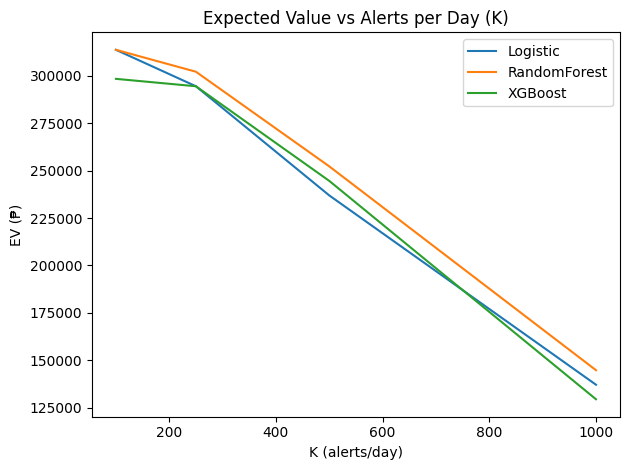

✅ Saved fraud-capstone/reports/figures/ev_vs_k.png
✅ Saved fraud-capstone/reports/test_operating_point.csv


In [21]:
#models file
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Use selected features if available
sel_cols = [ln.strip() for ln in Path("fraud-capstone/reports/selected_features.txt").read_text().splitlines() if ln.strip()]
X_train_s, X_val_s, X_test_s = X_train[sel_cols], X_val[sel_cols], X_test[sel_cols]

neg, pos = (y_train==0).sum(), (y_train==1).sum()
scale_pos = max(1.0, neg / max(pos,1))

models = {
    "Logistic": LogisticRegression(max_iter=400, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=8, n_jobs=-1,
                                          class_weight="balanced_subsample", random_state=42),
    "XGBoost": XGBClassifier(n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.9,
                             colsample_bytree=0.8, reg_lambda=1.0, n_jobs=-1, random_state=42,
                             scale_pos_weight=scale_pos, eval_metric='logloss', tree_method='hist'),
}

C_fraud, C_review, C_fp = 7500.0, 80.0, 150.0

def eval_at_tau(scores, y_true, tau):
    pred = (scores >= tau).astype(int)
    TP = int(((pred==1) & (y_true==1)).sum())
    FP = int(((pred==1) & (y_true==0)).sum())
    FN = int(((pred==0) & (y_true==1)).sum())
    TN = int(((pred==0) & (y_true==0)).sum())
    precision = TP / max(TP+FP, 1)
    recall = TP / max(TP+FN, 1)
    fpr = FP / max(FP+TN, 1)
    alerts = TP + FP
    EV = TP*C_fraud - alerts*C_review - FP*C_fp
    return precision, recall, fpr, EV, TP, FP, FN, TN

def tau_for_topK(scores, K):
    s = np.sort(scores)[::-1]; K = min(K, len(s))
    return s[K-1] if K>0 else 1.1

def tau_for_fpr(scores, y_true, cap):
    fpr, tpr, thr = roc_curve(y_true, scores)
    m = fpr <= cap
    return thr[m][-1] if m.any() else thr[np.argmin(fpr)]

rows = []
for name, model in models.items():
    model.fit(X_train_s, y_train)
    try:
        val_scores = model.predict_proba(X_val_s)[:,1]
    except:
        val_scores = model.decision_function(X_val_s)

    ap, roc = average_precision_score(y_val, val_scores), roc_auc_score(y_val, val_scores)

    # Top-K modes
    for K in [100, 250, 500, 1000]:
        tauK = tau_for_topK(val_scores, K)
        p, r, f, ev, TP, FP, FN, TN = eval_at_tau(val_scores, y_val.values, tauK)
        rows.append([name, f'K={K}', tauK, K, ap, roc, p, r, f, ev, TP, FP, FN, TN])

    # FPR caps
    for cap in [0.005, 0.01, 0.02]:
        tauf = tau_for_fpr(val_scores, y_val.values, cap)
        p, r, f, ev, TP, FP, FN, TN = eval_at_tau(val_scores, y_val.values, tauf)
        rows.append([name, f'FPR≤{int(cap*100)}%', tauf, int((val_scores>=tauf).sum()), ap, roc, p, r, f, ev, TP, FP, FN, TN])

res = pd.DataFrame(rows, columns=['model','mode','tau','alerts','AP','ROC_AUC','precision','recall','fpr','EV','TP','FP','FN','TN'])
out_path = Path("fraud-capstone/reports/model_compare_val.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
res.to_csv(out_path, index=False)
print("✅ Saved", out_path)

# EV vs K figure
subset = res[res['mode'].str.startswith('K=')].copy()
subset['K'] = subset['mode'].str.replace('K=', '').astype(int)
plt.figure()
for m in subset['model'].unique():
    d = subset[subset['model']==m]
    plt.plot(d['K'], d['EV'], label=m)
plt.title('Expected Value vs Alerts per Day (K)')
plt.xlabel('K (alerts/day)'); plt.ylabel('EV (₱)'); plt.legend(); plt.tight_layout()
plt.savefig("fraud-capstone/reports/figures/ev_vs_k.png", dpi=150)
plt.show()
print("✅ Saved fraud-capstone/reports/figures/ev_vs_k.png")

# Choose best model by EV under FPR≤0.5% on VAL → evaluate on TEST
best = None
for name, model in models.items():
    try:
        val_scores = model.predict_proba(X_val_s)[:,1]
    except:
        val_scores = model.decision_function(X_val_s)
    tauf = tau_for_fpr(val_scores, y_val.values, 0.005)
    p, r, f, ev, TP, FP, FN, TN = eval_at_tau(val_scores, y_val.values, tauf)
    if (best is None) or (ev > best['ev']):
        best = {'name': name, 'model': model, 'tau': tauf, 'ev': ev}

# Grid CSV (thresholds) — optional but handy
grid = []
name, model = best['name'], best['model']
try:
    val_scores = model.predict_proba(X_val_s)[:,1]
except:
    val_scores = model.decision_function(X_val_s)
for K in [100,250,500,1000]:
    grid.append(['K',K,tau_for_topK(val_scores,K)])
for cap in [0.0,0.005,0.01,0.02]:
    grid.append(['FPR',cap,tau_for_fpr(val_scores, y_val.values, cap)])
pd.DataFrame(grid, columns=['mode','value','tau']).to_csv("fraud-capstone/reports/threshold_grid.csv", index=False)

# TEST at chosen tau
try:
    test_scores = best['model'].predict_proba(X_test_s)[:,1]
except:
    test_scores = best['model'].decision_function(X_test_s)
tau = best['tau']
pred = (test_scores >= tau).astype(int)
TP = int(((pred==1)&(y_test==1)).sum()); FP = int(((pred==1)&(y_test==0)).sum())
FN = int(((pred==0)&(y_test==1)).sum()); TN = int(((pred==0)&(y_test==0)).sum())
precision = TP/max(TP+FP,1); recall = TP/max(TP+FN,1); fpr = FP/max(FP+TN,1); alerts=TP+FP
EV = TP*7500.0 - alerts*80.0 - FP*150.0

pd.DataFrame([{
    'model': best['name'], 'tau': tau, 'alerts': alerts,
    'precision': precision, 'recall': recall, 'fpr': fpr,
    'EV': EV, 'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN
}]).to_csv("fraud-capstone/reports/test_operating_point.csv", index=False)

print("✅ Saved fraud-capstone/reports/test_operating_point.csv")

In [22]:
#swarm and waterfall
%pip install -q pandas numpy scikit-learn shap

import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from pathlib import Path
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

# ---- Load data ----
csv_path = Path("data/creditcard.csv")
assert csv_path.exists(), "Missing data/creditcard.csv — run your upload cell first."
df = pd.read_csv(csv_path)

# ---- Recreate engineered features ----
q25, q75 = df['Amount'].quantile([0.25, 0.75]); iqr = max(q75-q25, 1e-9)
df['Amount_log'] = np.log1p(df['Amount'])
df['Amount_rz']  = (df['Amount'] - q25) / iqr
if 'Time' in df.columns:
    secs = df['Time'] % (24*3600); frac = secs/(24*3600)
    df['Time_sin'] = np.sin(2*np.pi*frac); df['Time_cos'] = np.cos(2*np.pi*frac)

base_cols = [c for c in df.columns if c.startswith('V')]
fe_cols   = ['Amount','Amount_log','Amount_rz'] + (['Time_sin','Time_cos'] if 'Time_sin' in df.columns else [])
X_all = df[base_cols + fe_cols].copy()
y_all = df['Class'].astype(int)

# Optional: use saved feature subset
sel_path = Path("fraud-capstone/reports/selected_features.txt")
if sel_path.exists():
    selected = [ln.strip() for ln in sel_path.read_text().splitlines() if ln.strip()]
    selected = [c for c in selected if c in X_all.columns]
    if selected: X_all = X_all[selected]

# ---- Temporal 80/10/10 split ----
if 'Time' in df.columns:
    order = df['Time'].argsort().values
    X_all = X_all.iloc[order].reset_index(drop=True)
    y_all = y_all.iloc[order].reset_index(drop=True)

n = len(X_all)
cut1, cut2 = int(n*0.8), int(n*0.9)
X_train, y_train = X_all.iloc[:cut1], y_all.iloc[:cut1]
X_val,   y_val   = X_all.iloc[cut1:cut2], y_all.iloc[cut1:cut2]

# ---- Fit RandomForest ----
rf = RandomForestClassifier(
    n_estimators=300, max_depth=8, n_jobs=-1,
    class_weight="balanced_subsample", random_state=42
)
rf.fit(X_train, y_train)

# ---- SHAP explainer (unified API) ----
bg = X_train.sample(n=min(1000, len(X_train)), random_state=42)   # background
explainer = shap.Explainer(rf, bg)                                # picks TreeExplainer
val_bg = X_val.sample(n=min(1000, len(X_val)), random_state=42)   # sample to plot
exp_val = explainer(val_bg, check_additivity=False)                # Explanation

# Slice to the FRAUD class (class index 1) if multi-output
try:
    exp_val_cls1 = exp_val[:, :, 1]   # works for multi-output Explanation
except Exception:
    # fallback: single-output models
    exp_val_cls1 = exp_val

figs_dir = Path("fraud-capstone/reports/figures")
figs_dir.mkdir(parents=True, exist_ok=True)

# ---- Beeswarm (global importance, class 1) ----
plt.figure()
shap.plots.beeswarm(exp_val_cls1, show=False)
plt.tight_layout()
plt.savefig(figs_dir / "shap_beeswarm.png", dpi=150)
plt.close()
print("✅ Saved", figs_dir / "shap_beeswarm.png")

# ---- Pick TP and FP on VALIDATION for waterfalls ----
try:
    val_scores = rf.predict_proba(X_val)[:,1]
except:
    val_scores = rf.decision_function(X_val)

fpr, tpr, thr = roc_curve(y_val, val_scores)
mask = fpr <= 0.005
tau = thr[mask][-1] if mask.any() else thr[np.argmin(fpr)]
pred_val = (val_scores >= tau).astype(int)

TP_idx = np.where((pred_val==1) & (y_val.values==1))[0]
FP_idx = np.where((pred_val==1) & (y_val.values==0))[0]

def save_waterfall(idx, out_path):
    exp_one = explainer(X_val.iloc[[idx]], check_additivity=False)
    # slice to class 1 if multi-output
    try:
        exp_one = exp_one[:, :, 1]
    except Exception:
        pass
    shap.plots.waterfall(exp_one[0], show=False)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()
    print("✅ Saved", out_path)

# TP example (fallbacks if none at tau)
if len(TP_idx)>0:
    save_waterfall(int(TP_idx[0]), figs_dir / "shap_waterfall_TP.png")
else:
    pos_idxs = np.where(y_val.values==1)[0]
    if len(pos_idxs)>0:
        i = int(pos_idxs[np.argmax(val_scores[pos_idxs])])
        save_waterfall(i, figs_dir / "shap_waterfall_TP.png")

# FP example (fallbacks if none at tau)
if len(FP_idx)>0:
    save_waterfall(int(FP_idx[0]), figs_dir / "shap_waterfall_FP.png")
else:
    neg_idxs = np.where(y_val.values==0)[0]
    if len(neg_idxs)>0:
        i = int(neg_idxs[np.argmax(val_scores[neg_idxs])])
        save_waterfall(i, figs_dir / "shap_waterfall_FP.png")

 96%|=================== | 1925/2000 [00:26<00:01]       

✅ Saved fraud-capstone/reports/figures/shap_beeswarm.png
✅ Saved fraud-capstone/reports/figures/shap_waterfall_TP.png
✅ Saved fraud-capstone/reports/figures/shap_waterfall_FP.png


In [23]:
#Fairness Slice
import pandas as pd, numpy as np
from pandas.api.types import is_numeric_dtype
from pathlib import Path

# Need test scores at chosen tau using RF
try:
    test_scores = rf.predict_proba(X_test_s)[:,1]
except:
    test_scores = rf.decision_function(X_test_s)
tau = tau_for_fpr(rf.predict_proba(X_val_s)[:,1], y_val.values, 0.005)
pred_test = (test_scores >= tau).astype(int)

# Amount quartiles
amt_bins = pd.qcut(df.iloc[len(X_train)+len(X_val):]['Amount'], q=4, duplicates='drop')
# Hour-of-day proxy if Time exists
if 'Time' in df.columns:
    secs = df.iloc[len(X_train)+len(X_val):]['Time'] % (24*3600); hour = (secs//3600).astype(int)
    hour_bin = pd.cut(hour, bins=[-1,6,12,18,24], labels=['Night','Morning','Afternoon','Evening'])
else:
    hour_bin = pd.Series(['NA']*len(pred_test))

res = pd.DataFrame({
    'y': y_test.values, 'pred': pred_test,
    'Amount': df.iloc[len(X_train)+len(X_val):]['Amount'].values,
    'amt_bin': amt_bins.astype(str).values,
    'hour_bin': hour_bin.astype(str).values
})

def summarize(group):
    n = len(group)
    alerts = int((group['pred']==1).sum())
    tp = int(((group['pred']==1) & (group['y']==1)).sum())
    prec = tp / max(alerts,1)
    alert_rate = alerts / max(n,1)
    return pd.Series({'n': n, 'alerts': alerts, 'alert_rate': alert_rate, 'precision': prec})

amt_tbl  = res.groupby('amt_bin', observed=True, dropna=False).apply(summarize).reset_index()
hour_tbl = res.groupby('hour_bin', observed=True, dropna=False).apply(summarize).reset_index()

amt_tbl.insert(0, 'slice', amt_tbl['amt_bin']);  amt_tbl['group']  = 'Amount';   amt_tbl = amt_tbl[['slice','n','alerts','alert_rate','precision','group']]
hour_tbl.insert(0,'slice', hour_tbl['hour_bin']); hour_tbl['group'] = 'HourOfDay'; hour_tbl = hour_tbl[['slice','n','alerts','alert_rate','precision','group']]

out = pd.concat([amt_tbl, hour_tbl], axis=0, ignore_index=True)
out.to_csv("fraud-capstone/reports/fairness_slices_test.csv", index=False)
print("✅ Saved fraud-capstone/reports/fairness_slices_test.csv")

✅ Saved fraud-capstone/reports/fairness_slices_test.csv


In [24]:
# Collect artifacts into the repo and create the final zip
import os, glob, shutil, zipfile
from pathlib import Path

repo = Path("fraud-capstone")
assert repo.exists(), "Missing ./fraud-capstone — create it first (README/requirements step)."

reports = repo / "reports"
figs    = reports / "figures"
reports.mkdir(parents=True, exist_ok=True)
figs.mkdir(parents=True, exist_ok=True)

# --- What we expect ---
must_roots = ["README.md", "requirements.txt", ".gitignore"]
report_files = [
    "data_dictionary.csv",
    "model_compare_val.csv",
    "test_operating_point.csv",
    "fairness_slices_test.csv",
    "selected_features.txt",
    "threshold_grid.csv",
]
figure_files = [
    "shap_beeswarm.png",
    "shap_waterfall_TP.png",
    "shap_waterfall_FP.png",
    "ev_vs_k.png",
]
optional_dirs = ["models", "notebooks", "src"]

# --- Copy helper ---
def ensure_in_repo(filename, dest_dir):
    dest = dest_dir / filename
    if dest.exists():
        return str(dest), "already_in_repo"
    hits = [p for p in glob.glob(f"**/{filename}", recursive=True) if "sample_data/" not in p]
    if hits:
        src = max(hits, key=lambda p: os.path.getmtime(p))  # pick newest
        shutil.copy2(src, dest)
        return src, "copied"
    return None, "missing"

found, missing = [], []

# 1) Make sure root files exist (README.md, requirements.txt, .gitignore)
for f in must_roots:
    p = repo / f
    if p.exists():
        found.append(f"{f} (in repo)")
    else:
        missing.append(f)

# 2) Collect report CSV/TXT artifacts
for f in report_files:
    src, status = ensure_in_repo(f, reports)
    if status == "missing":
        missing.append(f"reports/{f}")
    else:
        found.append(f"reports/{f}  ←  {src}")

# 3) Collect figure PNGs
for f in figure_files:
    src, status = ensure_in_repo(f, figs)
    if status == "missing":
        missing.append(f"reports/figures/{f}")
    else:
        found.append(f"reports/figures/{f}  ←  {src}")

# 4) Include optional dirs if present anywhere (copy into repo root if not already there)
for d in optional_dirs:
    dp = repo / d
    if dp.exists():
        found.append(f"{d}/ (in repo)")
        continue
    hits = [p for p in glob.glob(f"**/{d}", recursive=True) if os.path.isdir(p) and not p.startswith("sample_data/")]
    if hits:
        src = max(hits, key=lambda p: os.path.getmtime(p))
        shutil.copytree(src, dp, dirs_exist_ok=True)
        found.append(f"{d}/  ←  {src}")

# --- Zip (exclude data/, .git, checkpoints, pycache) ---
exclude_dirs = {"data", ".git", ".ipynb_checkpoints", "__pycache__"}
zip_path = Path("fraud-capstone-bundle.zip")

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in repo.rglob("*"):
        if p.is_dir():
            continue
        if any(x in p.parts for x in exclude_dirs):
            continue
        arc = p.relative_to(repo.parent)  # keep top-level folder name
        zf.write(p, arcname=str(arc))

print(f"✅ Created {zip_path}")

# Summary
print("\nIncluded / found:")
for x in found:
    print("  -", x)

if missing:
    print("\n⚠️ Missing (not found anywhere this runtime):")
    for m in missing:
        print("  -", m)
else:
    print("\nAll expected artifacts are present.")

# One-click download in Colab (best effort)
try:
    from google.colab import files
    files.download(str(zip_path))
except Exception:
    pass

✅ Created fraud-capstone-bundle.zip

Included / found:
  - README.md (in repo)
  - requirements.txt (in repo)
  - .gitignore (in repo)
  - reports/data_dictionary.csv  ←  fraud-capstone/reports/data_dictionary.csv
  - reports/model_compare_val.csv  ←  fraud-capstone/reports/model_compare_val.csv
  - reports/test_operating_point.csv  ←  fraud-capstone/reports/test_operating_point.csv
  - reports/fairness_slices_test.csv  ←  fraud-capstone/reports/fairness_slices_test.csv
  - reports/selected_features.txt  ←  fraud-capstone/reports/selected_features.txt
  - reports/threshold_grid.csv  ←  fraud-capstone/reports/threshold_grid.csv
  - reports/figures/shap_beeswarm.png  ←  fraud-capstone/reports/figures/shap_beeswarm.png
  - reports/figures/shap_waterfall_TP.png  ←  fraud-capstone/reports/figures/shap_waterfall_TP.png
  - reports/figures/shap_waterfall_FP.png  ←  fraud-capstone/reports/figures/shap_waterfall_FP.png
  - reports/figures/ev_vs_k.png  ←  fraud-capstone/reports/figures/ev_vs_k.p

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# After you have y_test, test_scores (probabilities), and your chosen tau / K:

C_fraud, C_review, C_fp = 7500.0, 80.0, 150.0

def ev_breakdown(scores, y_true, tau):
    pred = (scores >= tau).astype(int)
    TP = int(((pred==1) & (y_true==1)).sum())
    FP = int(((pred==1) & (y_true==0)).sum())
    FN = int(((pred==0) & (y_true==1)).sum())
    TN = int(((pred==0) & (y_true==0)).sum())
    alerts = TP + FP
    precision = TP / max(TP+FP, 1)
    recall = TP / max(TP+FN, 1)
    fpr = FP / max(FP+TN, 1)
    EV = TP*C_fraud - alerts*C_review - FP*C_fp
    return dict(TP=TP, FP=FP, FN=FN, TN=TN, alerts=alerts,
                precision=precision, recall=recall, fpr=fpr, EV=EV)

out = ev_breakdown(test_scores, y_test.values, tau)
out

{'TP': 16,
 'FP': 49,
 'FN': 6,
 'TN': 28410,
 'alerts': 65,
 'precision': 0.24615384615384617,
 'recall': 0.7272727272727273,
 'fpr': 0.0017217751853543695,
 'EV': 107450.0}

In [27]:
SECONDS_PER_DAY = 86400

# Use the raw split dataframe, not X_test
if 'Time' in test.columns:
    test_days = (test['Time'].max() - test['Time'].min()) / SECONDS_PER_DAY
else:
    test_days = None

test_days


0.1753587962962963

In [30]:
#test validation data
out = ev_breakdown(test_scores, y_test.values, tau)

if test_days and test_days > 0:
    out["EV_per_day"] = out["EV"] / test_days
    out["alerts_per_day"] = out["alerts"] / test_days

out

{'TP': 16,
 'FP': 49,
 'FN': 6,
 'TN': 28410,
 'alerts': 65,
 'precision': 0.24615384615384617,
 'recall': 0.7272727272727273,
 'fpr': 0.0017217751853543695,
 'EV': 107450.0,
 'EV_per_day': 612743.7132862518,
 'alerts_per_day': 370.6686027324929}

In [29]:
#double check
test_days
test['Time'].min(), test['Time'].max()
(test['Time'].max() - test['Time'].min())/86400

0.1753587962962963